# A gentle introduction to Stable Diffusion - Part 1 (Introduction to Latent Diffusion Models)

Hello and welcome to this explainer for Stable Diffusion - specifically targeting a non-technical audience. This will be a quick rundown of how *Latent Diffusion Models* (LDMs) work, specifically focusing on Stable Diffusion v1.4, as it is probably the most intuitive to explain.

This explainer will be split into multiple parts - first, we will give a high level overview of the model cascade itself, then we'll go into each component of the cascade, and finally, we'll put the model cascade together at the end!

This is the first section out of five: a high level overview of Latent Diffusion Models in general. The other sections are accessible [here](https://research.qut.edu.au/genailab/projects/unboxing-genai/).

1. Introduction to Latent Diffusion Models
2. CLIP Text embedder
3. Variational AutoEncoder
4. UNet denoiser
5. Conclusion - putting it all together



## Some (brief) history

Text-to-image models are a fairly recent endeavour in the history of machine learning and AI research. For decades prior, the inverse task (image-to-text) was a much bigger focus in machine learning research, examples of this being Optical Character Recognition (OCR) and image captioning. Text-to-image was a significantly harder challenge, with higher dimensionality and variance in the output data - essentially, it was a lot easier to get a computer to write, than it was to get a computer to draw.

The first attempt at a text-to-image model that created images from scratch (prior attempts relied on discrete collages of exsiting images) was alignDRAW in 2015. This model, developed at the University of Toronto by [Mansimov et. al.](https://arxiv.org/pdf/1511.02793), used a recurrent Variational AutoEncoder (which we will cover in this tutorial!) and an LSTM (an early language embedding model) to generate 32x32 resolution images. The images were both low resolution and not particularly detailed, but the outputs showed promising results in guiding image outputs based on text prompts.

![alignDRAW_example.png](https://github.com/QUT-GenAI-Lab/genai-explained/blob/main/notebooks/SD_explainer_assets/alignDRAW_example.png?raw=true)

*Examples of images generated using the early alignDRAW model*

Shortly after that, attempts were made to leverage Generative Adversarial Networks (GANs) for text-to-image tasks. The first attempt at this was a Conditional Generative Adversarial Network (CGAN) conditioned on free-text embeddings proposed by [Reed et al. in 2016](https://arxiv.org/pdf/1605.05396) (prior CGANs used a fixed set of class labels, rather than free-text). This added a conditional LSTM embedding to a GAN, and improved greatly upon output quality compared to alignDRAW. Research into this approach continued for another 6 or so years with significant improvements -  examples of this approach include [VQGAN-CLIP](https://arxiv.org/pdf/2204.08583) and [XMC-GAN](https://arxiv.org/pdf/2101.04702). Despite no longer being the current state-of-the-art, research into this approach of image generation still persists given several inherent advantages of GAN-based generation over Latent Diffusion Model-based generation.

![tcgan_example.png](https://github.com/QUT-GenAI-Lab/genai-explained/blob/main/notebooks/SD_explainer_assets/tcgan_example.png?raw=true)

*Examples of images generated with the text-CGAN model*

![VQGAN-CLIP_example.png](https://github.com/QUT-GenAI-Lab/genai-explained/blob/main/notebooks/SD_explainer_assets/VQGAN-CLIP_example.png?raw=true)

*Examples of images generated with the VQGAN-CLIP model*

However, what arose most recently as the state-of-the-art (SOTA) approach for text-to-image generation was Latent Diffusion Models (LDMs). Popularity of this approach skyrocketed in 2022 with the release of both [Stable Diffusion from Stability.AI](https://arxiv.org/pdf/2112.10752), and [Dall-E 2 from OpenAI](https://arxiv.org/pdf/2204.06125). These models not only increased the fidelity and realism of the output images over previous attempts, but also demonstrated far better adherence to the input text prompts. As of the creation of this explainer series (August 2024), this approach to text-to-image generation remains SOTA, but as with a lot of things in deep learning, there is every possibility it will be superceded!

![SD_examples.png](https://github.com/QUT-GenAI-Lab/genai-explained/blob/main/notebooks/SD_explainer_assets/SD_examples.png?raw=true)

*Example images generated with Stability AI's Stable Diffusion model*

![dalle2_examples.png](https://github.com/QUT-GenAI-Lab/genai-explained/blob/main/notebooks/SD_explainer_assets/dalle2_examples.png?raw=true)

*Example images generated with OpenAI's Dall-E 2 model*

## Some terminology

So what is a Latent Diffusion Model, anyway?

Well first let's define the terms *diffusion* and *latent*.


### Diffusion

*Diffusion* is actually a pretty generic concept that most of us would be familiar with, but in this case the meaning of the word diffusion might not be intuitive.

Imagine an air freshener, or an essential oil diffuser. The scent comes in a liquid, but then gets *diffused* into the air - in thermodynamic terms, the liquid particles go from being in a more concentrated, structured space (the inside of the air freshener) to a less concentrated, randomly distributed space (the room in which you are freshening air).

Diffusion of image data works analogously - we can take an image and its data (the pixels), and *diffuse* their distribution. That is, the structure (position) and colour of the pixels which make up the image are shifted and increasingly distributed toward completely random noise.

In essence (hah), the diffusion process on an image takes it from a recognisable image to completely randomly distributed noise, in the same way that an essential oil diffuser takes oil from a concentrated liquid to a set of dispersed particles in the air.

### Latent

*Latent* in general parlance means "hidden" or "dormant", and in the field of Machine/Deep Learning also means the same thing; a latent space is a hidden state within a model, not intended to be viewed as one of the model outputs. This generally also means latent values are a set of numbers that are supposed to represent information that is useful and descriptive to the model in some way, in that latent values can be used to generate something meaningful down the line. Usually, a latent space is also a lot smaller (in terms of data) than the corresponding input space - otherwise you may as well just preserve the input data!

Typically then, **a latent space is used to compress/re-represent data, while preseving as much (relevant) detail as possible**. A conceptually similar example of this in everyday life is a map - we could arguably navigate via satellite photos of the earth, but what we choose to use is abstracted, lower detail representations of the details we care about - paths, path-types, and in some cases topography/terrain type (could be sea, grassy, concrete, etc.). So in a sense, you can think of a latent space as a specialised "map" of numbers, in lower detail than the original input, that the model can meaningfully use to infer information from the original data.

In the context of Latent Diffusion models, a latent space is used to compress an image into a much smaller size. For example, with Stable Diffusion the latent space transforms an image with a resolution of 512x512 pixels and 'resizes' / compresses / re-represents it in space of 64x64 pixels, while trying to preserve all the relevant details (more detail on this later in this series). This is required to make the computer's job a lot easier when it comes to understanding the data it's being fed.

Going back to our map example - imagine having to navigate with satellite images instead of maps!

---

Putting these concepts back together, we can then understand that Latent Diffusion Models **model the diffusion of latent space**.

In our essential oil diffuser example, you can think of this model as understanding how the vapours of the essential oil *diffuse* into the air over time. Understanding this, we can then apply this to the latent representation of an image, where our model *learns how pixels will diffuse over time in a noising process*. The big thing to note here though, is that if you understand how a particular object, material, or data diffuses, *you should also be able to model how to reverse that process*, which is how latent diffusion models work to generate images - they will start from completely random noise, and then from there, they will predict what the image is supposed to be, from the noise.

One practical thing to note - what researchers found in practice was that it was a lot more effective to add and subtract noise sequentially with a latent diffusion model to get a final image, and set the noise generation process to be a set of discrete timesteps, and so that's what we have today. LDMs start with a completely random 'noise' image, and then incrementally generate slightly more visually coherent images from that noise by denoising and then "renoising" with slightly less noise. Each time the image is denoised, the leftover image will have a little more detailed information in it than last time, and the image will be renoised a little bit less for the next loop around.

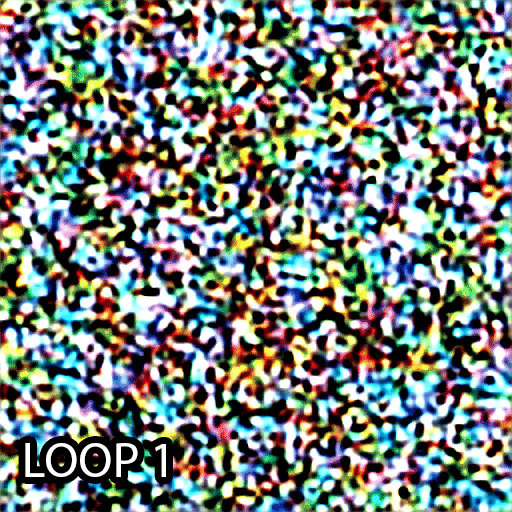

*A visualisation of the Stable Diffusion denoise and renoise loop over 10 steps*


### Adding text in to the mix
What was described above was Latent Diffusion by itself - essentially, this is what would happen if you put no text into a text-to-image generator. Without "guidance" from a text prompt, all that results from a latent diffusion model will be a random image, that will change randomly based on the noise pattern that the diffusion model starts with. Text-to-image models build on this approach by augmenting the denoising model so that the denoising process can be "guided" by the text instructions, leaving behind specific details in the structure once the noise is removed. In doing so, we finally get the model cascade that allows you to put in text, and then have an image (as described by the text!) generated!


In a sense, you can think of LDMs as sculptors more so than illustrators - they take a noisy block of raw stone, and carve out their image, rather than taking a blank canvas and painting an image from scratch.


## The Stable Diffusion v1.4 Architecture

### The model cascade

Latent Diffusion Models are actually a "cascade" of models.

What that means is that they are actually made up of several smaller models that work together to create one big system where one model's output feeds into another's input - sort of like a factory production line. For latent diffusion models, the high level logic of the model cascade is as follows:

1. **Text embedder:** this model takes the text prompt, and turns it into a series of numbers that the computer can understand, when are passed to the other models down the line.
   
2. **Image compressor:** this is a deep learning model which specialises in compressing data into a smaller size, while preserving as much information as possible. You can imagine this to be like an image compression algorithm like JPEG, but far more efficient at storing the certain kinds of data (specifically, the kinds of images that are used in the training process). This step is important as it allows the whole system to use much less computational power, because the compressed image representation is smaller than the raw image, so all of the other model cascade steps can also be smaller.

3. **Denoising model:** this is the core of the system - essentially, it takes the compressed image from step 2, and denoises it while leaving behind structure that resembles the text input.


In the case of Stable Diffusion v1.4, the model cascade is as follows (don't worry if it's a little hard to follow at the moment - we'll go into each model in their own section):

1. [**Text Embedder: CLiP-ViT-L/14 -**](https://arxiv.org/pdf/2103.00020) This is an open-source text-embedder and image-embedder model, which was fine-tuned specifically for searching for images with text inputs. Essentially, if you type the word "dog" into a CLiP-powered search engine, this model will return a picture of a dog.
Likewise, if you put a picture of a dog into a CLiP powered search engine, the model might return text phrases related to dogs.
2. [**Image compressor: Variational Auto-Encoder (VAE) -**](https://arxiv.org/pdf/1906.02691) This model is specifically designed to take 512x512 resolution images, and compress them into 64x64 "images" without losing quality. Because of the size difference, you can think of this model as making images **64x** smaller, but without losing much visual quality.

3. [**Denoising model: UNet with Conditional Generation -**](https://sdxlturbo.ai/blog-The-UNet-actually-explained-in-10-minutes-19074) This model is a type of model called a 'UNet' (which comes from the shape of the model architecture - it looks like the letter 'U'!), with a few layers added in for "guidance" from the text embedding. Newer Stable Diffusion models use far more sophisticated architectures to denoise their compressed images, but this is probably the easiest to intuitively understand and explain!


With all of this explained, hopefully now, with some helpful additional labelling, we can intuit how the model is working in this diagram, published in their first [Stable Diffusion paper.](https://arxiv.org/pdf/2112.10752)

![sd_breakdown.png](https://github.com/QUT-GenAI-Lab/genai-explained/blob/main/notebooks/SD_explainer_assets/sd_breakdown.png?raw=true)

The high-level logic described above (the text embedder, image compresser, and denoiser) is generally preserved across all iterations of Stable Diffusion - the only things that change over time are the models in each piece of the puzzle. [Stable Diffusion XL](https://openreview.net/pdf?id=di52zR8xgf), for example, adds an additional text embedder ([OpenCLIP ViT-bigG](https://huggingface.co/laion/CLIP-ViT-bigG-14-laion2B-39B-b160k)), and then adds an additional, optional, sequential model to its denoising algorithm. Stable Diffusion 2 uses a different text embedder again, and changes the denoising algorithm from a UNet to [v-prediction](https://arxiv.org/pdf/2202.00512). 

Further still, *this logic also generalises to almost all popular generative text-input models we have today*, including other text-to-image models like [Dall-E 2](https://cdn.openai.com/papers/dall-e-2.pdf) and [Imagen](https://deepmind.google/technologies/imagen-3/), text-to audio models like [MusicGen](https://musicgen.com/) and [Riffusion](https://www.riffusion.com/), and text-to-video models like [CogVideo](https://github.com/THUDM/CogVideo) and [HotShot-XL](https://huggingface.co/hotshotco/Hotshot-XL). If you understand the high-level concepts of this tutorial series, you should be able to generalise this understanding to almost all diffusion-based generative models that are currently available!

*IF MODULE GETS ADDED* - add stuff here linking to final module going through text-to-audio and text-to-video.

---

## The training data used on Stable Diffusion V1.4

Like any deep learning model, the Stable Diffusion model cascade had to be trained on a large dataset to be able to turn text inputs into images. The [very first Stable Diffusion paper](https://arxiv.org/pdf/2112.10752) presented the results of a model trained on [LAION-400m](https://laion.ai/blog/laion-400-open-dataset/) - an open-source dataset which has been extracted from the [Common Crawl](https://commoncrawl.org/) dataset and then cleaned using OpenAI's [CLiP](https://openai.com/index/clip/) model. As per its name, the dataset has over 400 million text-image pairs in it, of varying sizes and dimensions. You can explore the dataset [here](https://rom1504.github.io/clip-retrieval/?back=https%3A%2F%2Fknn.laion.ai&index=laion5B-H-14&useMclip=false).

With each minor version iteration (i.e. SD 1.1, SD 1.2, SD 1.3 etc), Stability.AI typically fine-tuned the previous model with a new dataset - essentially, they took the old model that had already been trained, and then introduced new data to it to update weights. These updated datasets would typically be datasets curated by LAION to be focused on aesthetics - an example of which is [LAION-Aesthetics V1](https://github.com/LAION-AI/laion-datasets/blob/main/laion-aesthetic.md). 

Although out of the scope of this tutorial series, it is worth considering the contents and provenance of training data in these large generative models for multiple reasons. For one, a generative model like Stable Diffusion will only ever be able to generate content that is within the conceptual bounds of what it's seen before. Essentially, if there is not a single picture and/or text description of a Unicorn in Stable Diffusion's training data, there is now ay that the stable diffusion model would be able to generate a picture of a unicorn. Additionally, the provenance and content of the data can at times be [controversial](https://arstechnica.com/tech-policy/2024/08/nonprofit-scrubs-illegal-content-from-controversial-ai-training-dataset/#:~:text=After%20backlash%2C%20LAION%20cleans%20child,materials%20from%20AI%20training%20data.&text=After%20Stanford%20Internet%20Observatory%20researcher,immediately%20taken%20down%20in%202023.), particularly given the nature of the data's downstream use. 

---

## Now that we've done a high level overview of Stable Diffusion, let's start with our first deep dive into one of the models - the text embedder.